In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import torch.nn.functional as F
from tqdm import tqdm
import copy
import collections

In [2]:
def gen_data(n, d, p, scale=1.0):
    ys = torch.distributions.Bernoulli(torch.tensor(p)).sample((n, 1))
    zs = torch.randn(n, d)
    xs = zs + scale * (2*ys-1)
    return xs.float(), ys

In [3]:
def gen_data2(n, d, p, scale = 1.0):
    ys = torch.distributions.Bernoulli(torch.tensor(p)).sample((n, 1))
    zs = torch.randn(n, d)
    sw = torch.distributions.Bernoulli(torch.tensor(.25)).sample((n, 1))
    xs = zs + scale * (2*ys-1)*(1-2*sw)
    return xs.float(), ys

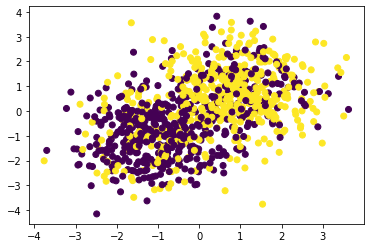

In [4]:
xs, ys = gen_data2(1000, 10, 0.5)
plt.scatter(xs[:, 0], xs[:, 1], c=ys[:, 0])

In [5]:
def evaluate(model, x, y):
    return((model(x) > 0.5) == y).float().mean().item()

In [6]:
def adapt(model, xTarget, yTarget, epochs=10000):
    accus = []
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    for i in tqdm(range(epochs)):
        optimizer.zero_grad()
        probPreds = model(xTarget)
        labelPreds = (probPreds > 0.5).float().detach()
        loss = F.binary_cross_entropy(probPreds, labelPreds)
        accus.append(evaluate(model, xTarget, yTarget))
        loss.backward()
        optimizer.step()
    return model, accus

In [7]:
n = 1000
d = 1

In [24]:
case1Accus = []
case2Accus = []
s = 1.5
torch.manual_seed(0)
for p in [0.5, 0.6, 0.7, 0.8, 0.9, 0.99]:
    model = nn.Sequential(nn.Linear(d, 1), nn.Sigmoid())
    model[0].weight.data = torch.tensor([[1.0]])
    model[0].bias.data = torch.tensor([0.0])
    xTarget, yTarget = gen_data2(n, d, p, scale=s)
    model, accus = adapt(model, xTarget, yTarget)
    case2Accus.append(evaluate(model, xTarget, yTarget))

    p2 = (1+2*p)/4
    model = nn.Sequential(nn.Linear(d, 1), nn.Sigmoid())
    model[0].weight.data = torch.tensor([[1.0]])
    model[0].bias.data = torch.tensor([0.0])
    xTarget, yTarget = gen_data(n, d, p2, scale=s)
    model, accus = adapt(model, xTarget, yTarget)
    case1Accus.append(evaluate(model, xTarget, yTarget))

100%|██████████| 10000/10000 [00:02<00:00, 3547.92it/s]


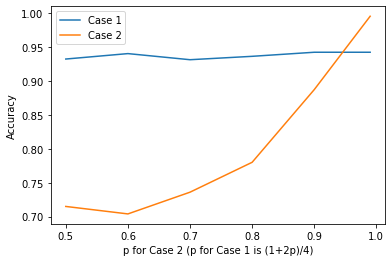

In [31]:
plt.plot([0.5, 0.6, 0.7, 0.8, 0.9, 0.99], case1Accus, label="Case 1")
plt.plot([0.5, 0.6, 0.7, 0.8, 0.9, 0.99], case2Accus, label="Case 2")
plt.xlabel("p for Case 2 (p for Case 1 is (1+2p)/4)")
plt.ylabel("Accuracy")
plt.legend()

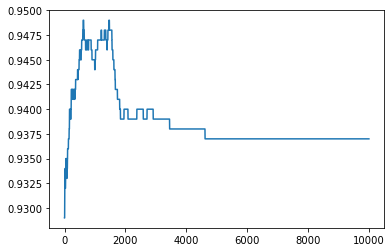

In [26]:
plt.plot(accus)

In [27]:
def train(model, x, y, classWeights, epochs = 1000):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    for i in tqdm(range(epochs)):
        optimizer.zero_grad()
        probPreds = model(x)
        loss = F.binary_cross_entropy(probPreds, y, weight=classWeights[y.long()])
        loss.backward()
        optimizer.step()
    return model

def confusion(preds, labels):
    c = torch.zeros(2, 2)
    for i in range(2):
        for j in range(2):
            c[i, j] = ((preds == i) & (labels == j)).float().sum().item()
    return c/c.sum()

def bbseEsti(model, xSource, ySource, xTarget):
    preds = model(xSource)
    preds = (preds > 0.5).float().detach()
    c = confusion(preds, ySource)
    preds = model(xTarget)
    preds = (preds > 0.5).float().detach()
    mu = torch.zeros(2)
    for i in range(2):
        mu[i] = (preds == i).float().mean().item()
    w = torch.inverse(c) @ mu
    return w

def adaptBBSE(model, xSource, ySource, xTarget, epochs = 10000):
    w = bbseEsti(model, xSource, ySource, xTarget)
    classWeights = torch.tensor([w[0], w[1]])
    model = train(model, xSource, ySource, classWeights, epochs)
    return model

In [28]:
case1Accus = []
case2Accus = []
s = 1.5
torch.manual_seed(0)
for p in [0.5, 0.6, 0.7, 0.8, 0.9, 0.99]:
    model = nn.Sequential(nn.Linear(d, 1), nn.Sigmoid())
    model[0].weight.data = torch.tensor([[1.0]])
    model[0].bias.data = torch.tensor([0.0])
    xSource, ySource = gen_data2(n, d, .5, scale = s)
    xTarget, yTarget = gen_data2(n, d, p, scale = s)
    model = adaptBBSE(model, xSource, ySource, xTarget)
    case2Accus.append(evaluate(model, xTarget, yTarget))

    p2 = (1+2*p)/4
    model = nn.Sequential(nn.Linear(d, 1), nn.Sigmoid())
    model[0].weight.data = torch.tensor([[1.0]])
    model[0].bias.data = torch.tensor([0.0])
    xSource, ySource = gen_data(n, d, .5, scale = s)
    xTarget, yTarget = gen_data(n, d, p2, scale = s)
    model = adaptBBSE(model, xSource, ySource, xTarget)
    case1Accus.append(evaluate(model, xTarget, yTarget))

100%|██████████| 10000/10000 [00:02<00:00, 4157.57it/s]


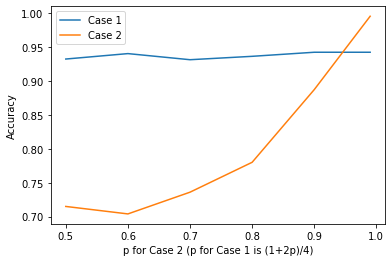

In [30]:
plt.plot([0.5, 0.6, 0.7, 0.8, 0.9, 0.99], case1Accus, label="Case 1")
plt.plot([0.5, 0.6, 0.7, 0.8, 0.9, 0.99], case2Accus, label="Case 2")
plt.xlabel("p for Case 2 (p for Case 1 is (1+2p)/4)")
plt.ylabel("Accuracy")
plt.legend()

In [78]:
xSource, ySource = gen_data2(1000, 1, 0.5)
xTarget, yTarget = gen_data2(1000, 1, 0.8)

In [79]:
model = nn.Sequential(nn.Linear(1, 1), nn.Sigmoid())
model[0].weight.data = torch.tensor([[1.0]])
model[0].bias.data = torch.tensor([0.0])

In [80]:
evaluate(model, xSource, ySource), evaluate(model, xTarget, yTarget)

(0.6449999809265137, 0.6710000038146973)

In [81]:
# w = bbseEsti(model, xSource, ySource, xTarget)
model = train(model, xSource, ySource, w)

100%|██████████| 1000/1000 [00:00<00:00, 3813.84it/s]


In [82]:
evaluate(model, xSource, ySource), evaluate(model, xTarget, yTarget)

(0.5429999828338623, 0.7860000133514404)